<a href="https://colab.research.google.com/github/opherdonchin/Regression-by-group/blob/main/Regression_analysis_t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample homogeneous and intercept models for slope of eyes and aftereffects

## Short description

The central idea is that eye movements reflect the implicit adaptation that is also revealed in the aftereffects. Thus, these two should be correlated. 
We measure the relationship using regression (I suppose we could have done correlation, eh?) and look at the slope of the regession line. However, because
both measures are quite noisy, we choose to have an error model for both the independent and dependent variables.

There are 2 different conditions in terms of what is on the screen (landmark or no landmarks) and each of those has multiple delay conditions (2 for landmarks (I think) 
and 3 for no landmarks (or the other way around)). The idea is to build separate (but identical) models for each of these 5 conditions and for each one to fit both an
intercept and homogeneous model.

So, there are two questions:

1. Is there a reason to prefer the intercept model to the homogeneous model?
2. Do any of the conditions show a relationship and do any show a lack of relationship?

I built this using the outline in this page: [Bayesian Linear Regression Using PyMC3](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

## Imports

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pymc3
    !pip install seaborn
    !pip install arviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports
# Python
import os.path
import pickle

# Maths
import numpy as np
import pandas as pd
import scipy.stats as stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Bayes
import theano.tensor as tt
import xarray as xr
import pymc3 as pm
import arviz as az


In [3]:
print('Running on the PyMC3 v{}'.format(pm.__version__))


Running on the PyMC3 v3.11.4


## Load data

In [6]:
# url_impl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_expl_trials = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/dataExplicit.csv'
# url_impl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
# url_expl = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/implAndAfter_NoLandmarks.csv'
url_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataLandmarks.csv'
url_no_landmarks = 'https://raw.githubusercontent.com/opherdonchin/Regression-by-group/main/data/dataNoLandmarks.csv'
# url_landmarks = 'data\dataLandmarks.csv'
# rl_no_landmarks = 'data\dataNoLandmarks.csv'

landmark_data = pd.read_csv(url_landmarks, sep=",", on_bad_lines='skip')
no_landmark_data = pd.read_csv(url_no_landmarks, sep=",", on_bad_lines='skip')

In [7]:
landmark_data.head()

,eyeHandDiff,eyes,afterEffect,subjectN,groups
0,10.082297,-31.546520,-8.875644,1,1
1,-10.012122,-27.271097,-3.625990,1,1
2,-33.441301,14.607681,-15.002860,1,1
3,-95.241374,57.084439,-11.144006,1,1
4,-121.630474,99.886312,-17.726672,1,1


## Create list of models

In [8]:
landmark_data["landmarks"] = True
no_landmark_data["landmarks"] = False
data = pd.concat([landmark_data, no_landmark_data], ignore_index=True)

independent_variables = ['eyeHandDiff', 'eyes']
x0_by_variable = [0, -30]
y0_by_variable = [0, 0]

b0_strings = ["intercept", "homogeneous"]

model_list = {b0_string: [] for b0_string in b0_strings}
for independent_variable,x0,y0 in zip(independent_variables,x0_by_variable,y0_by_variable):
    
    for landmarks in [True, False]:
        landmark_string = "landmarks" if landmarks else "no landmarks"
        this_landmark_data = data.loc[data["landmarks"]==landmarks,:]
        these_groups = this_landmark_data["groups"].unique()
        for group in these_groups:
            this_group_data = this_landmark_data.loc[data["groups"]==group,:]
            x = this_group_data[independent_variable]
            y = this_group_data['afterEffect']
            s = this_group_data['subjectN']
            
            for b0_string in b0_strings:
                model_name = f'{landmark_string} group {group} {b0_string} using {independent_variable}'
                model_list[b0_string].append({
                    'name': model_name,
                    'group': group,
                    'landmarks': landmark_string,
                    'variable': independent_variable,
                    'x': x,
                    'y': y,
                    's': s,
                    'x0': x0,
                    'y0': y0,
                    'use_b0': b0_string == b0_strings[0]
                })

model_list_out = open("model_list.pickle","wb")
pickle.dump(model_list, model_list_out)

## Define model

In [11]:
def regression_model(y,x,s,y0,x0,use_beta0):
  s_idx, s_vals = pd.factorize(s, sort=True)
  coords = {"subject": s_vals, "points":np.arange(len(x))}
  with pm.Model(coords=coords) as model:
    # Data
    s_idx = pm.Data("s_idx", s_idx, dims="points")
    x0 = pm.Data("x0", x0)
    y0 = pm.Data("y0", y0)
    # Priors
    beta = pm.Normal('beta', mu=0, sd=10, testval=0.0)
    if use_beta0:
      beta0 = pm.Normal('beta0', mu=0, sd=30, testval=0.0)
    y_sigma = pm.HalfNormal("y_sigma", sd=5, dims="subject")
    x_sigma = pm.HalfNormal("x_sigma", sd=5, dims="subject")
    ys_sigma = pm.HalfNormal("ys_sigma", sd=5)
    nu = pm.Exponential('nu', lam=0.1)

    # Latent variables
    xs = pm.Normal('xs', mu=0, sd=30, testval=0.0, dims="subject")
    if use_beta0:
      ys_mu = pm.Deterministic("ys_mu", beta*(xs-x0) + beta0+y0, dims="subject")
    else:
      ys_mu = pm.Deterministic("ys_mu", beta*(xs-x0) + y0, dims="subject")
    
    ys = pm.StudentT('ys', nu=nu, mu=ys_mu, sigma=ys_sigma, dims="subject")
    # Likelihood 
    obs_y = pm.Normal('obs_y', mu=ys[s_idx], sd=y_sigma[s_idx], observed=y, dims="points")
    obs_x = pm.Normal('obs_x', mu=xs[s_idx], sd=x_sigma[s_idx], observed=x, dims="points")
  return model


## Sample all models

In [13]:
all_idata = {b0_string: [] for b0_string in b0_strings}
num_models = len(model_list[b0_strings[0]])

do_models = np.arange(0,num_models)
for b0_string in b0_strings:
  for i,m in enumerate(model_list[b0_string]):
    print('************************')
    trace_path = f'samples\\y_sigma 02_06 {m["name"]}'
    model_description = f'{m["name"]} ({i}/{num_models} for {b0_string} model)'
    if not os.path.isfile(trace_path):
      print(f'Resampling {model_description}')
      model = regression_model(m["y"],m["x"],m["s"],m["y0"],m["x0"],m["use_b0"])
      with model:
        trace = pm.sample(draws=4000, tune=3000, target_accept=0.95)
      idata = az.from_pymc3(model=model, trace=trace)
      
      print(f'Saving samples for {m["name"]} to {trace_path}')
      az.to_netcdf(idata, trace_path)
    else:
      print(f'Loading samples for {model_description} from {trace_path}')
      idata = az.from_netcdf(trace_path)
    
    all_idata[b0_string].append(idata)
    print(f'Done getting {m["name"]} samples')
  

************************
Resampling landmarks group 1 intercept using eyeHandDiff (0/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 95 seconds.


Saving samples for landmarks group 1 intercept using eyeHandDiff to samples\y_sigma 02_06 landmarks group 1 intercept using eyeHandDiff
Done getting landmarks group 1 intercept using eyeHandDiff samples
************************
Resampling landmarks group 2 intercept using eyeHandDiff (1/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 94 seconds.


Saving samples for landmarks group 2 intercept using eyeHandDiff to samples\y_sigma 02_06 landmarks group 2 intercept using eyeHandDiff
Done getting landmarks group 2 intercept using eyeHandDiff samples
************************
Resampling landmarks group 3 intercept using eyeHandDiff (2/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 99 seconds.


Saving samples for landmarks group 3 intercept using eyeHandDiff to samples\y_sigma 02_06 landmarks group 3 intercept using eyeHandDiff
Done getting landmarks group 3 intercept using eyeHandDiff samples
************************
Resampling no landmarks group 1 intercept using eyeHandDiff (3/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 95 seconds.


Saving samples for no landmarks group 1 intercept using eyeHandDiff to samples\y_sigma 02_06 no landmarks group 1 intercept using eyeHandDiff
Done getting no landmarks group 1 intercept using eyeHandDiff samples
************************
Resampling no landmarks group 2 intercept using eyeHandDiff (4/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning: Data in obs_x contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [obs_x_missing, ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 98 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8758369320703613, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Saving samples for no landmarks group 2 intercept using eyeHandDiff to samples\y_sigma 02_06 no landmarks group 2 intercept using eyeHandDiff
Done getting no landmarks group 2 intercept using eyeHandDiff samples
************************
Resampling landmarks group 1 intercept using eyes (5/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 104 seconds.


Saving samples for landmarks group 1 intercept using eyes to samples\y_sigma 02_06 landmarks group 1 intercept using eyes
Done getting landmarks group 1 intercept using eyes samples
************************
Resampling landmarks group 2 intercept using eyes (6/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 100 seconds.


Saving samples for landmarks group 2 intercept using eyes to samples\y_sigma 02_06 landmarks group 2 intercept using eyes
Done getting landmarks group 2 intercept using eyes samples
************************
Resampling landmarks group 3 intercept using eyes (7/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 103 seconds.


Saving samples for landmarks group 3 intercept using eyes to samples\y_sigma 02_06 landmarks group 3 intercept using eyes
Done getting landmarks group 3 intercept using eyes samples
************************
Resampling no landmarks group 1 intercept using eyes (8/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 86 seconds.


Saving samples for no landmarks group 1 intercept using eyes to samples\y_sigma 02_06 no landmarks group 1 intercept using eyes
Done getting no landmarks group 1 intercept using eyes samples
************************
Resampling no landmarks group 2 intercept using eyes (9/10 for intercept model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta0, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 92 seconds.


Saving samples for no landmarks group 2 intercept using eyes to samples\y_sigma 02_06 no landmarks group 2 intercept using eyes
Done getting no landmarks group 2 intercept using eyes samples
************************
Resampling landmarks group 1 homogeneous using eyeHandDiff (0/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 96 seconds.


Saving samples for landmarks group 1 homogeneous using eyeHandDiff to samples\y_sigma 02_06 landmarks group 1 homogeneous using eyeHandDiff
Done getting landmarks group 1 homogeneous using eyeHandDiff samples
************************
Resampling landmarks group 2 homogeneous using eyeHandDiff (1/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 93 seconds.


Saving samples for landmarks group 2 homogeneous using eyeHandDiff to samples\y_sigma 02_06 landmarks group 2 homogeneous using eyeHandDiff
Done getting landmarks group 2 homogeneous using eyeHandDiff samples
************************
Resampling landmarks group 3 homogeneous using eyeHandDiff (2/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 94 seconds.


Saving samples for landmarks group 3 homogeneous using eyeHandDiff to samples\y_sigma 02_06 landmarks group 3 homogeneous using eyeHandDiff
Done getting landmarks group 3 homogeneous using eyeHandDiff samples
************************
Resampling no landmarks group 1 homogeneous using eyeHandDiff (3/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 79 seconds.


Saving samples for no landmarks group 1 homogeneous using eyeHandDiff to samples\y_sigma 02_06 no landmarks group 1 homogeneous using eyeHandDiff
Done getting no landmarks group 1 homogeneous using eyeHandDiff samples
************************
Resampling no landmarks group 2 homogeneous using eyeHandDiff (4/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning: Data in obs_x contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [obs_x_missing, ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 93 seconds.


Saving samples for no landmarks group 2 homogeneous using eyeHandDiff to samples\y_sigma 02_06 no landmarks group 2 homogeneous using eyeHandDiff
Done getting no landmarks group 2 homogeneous using eyeHandDiff samples
************************
Resampling landmarks group 1 homogeneous using eyes (5/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 97 seconds.


Saving samples for landmarks group 1 homogeneous using eyes to samples\y_sigma 02_06 landmarks group 1 homogeneous using eyes
Done getting landmarks group 1 homogeneous using eyes samples
************************
Resampling landmarks group 2 homogeneous using eyes (6/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 95 seconds.


Saving samples for landmarks group 2 homogeneous using eyes to samples\y_sigma 02_06 landmarks group 2 homogeneous using eyes
Done getting landmarks group 2 homogeneous using eyes samples
************************
Resampling landmarks group 3 homogeneous using eyes (7/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 94 seconds.


Saving samples for landmarks group 3 homogeneous using eyes to samples\y_sigma 02_06 landmarks group 3 homogeneous using eyes
Done getting landmarks group 3 homogeneous using eyes samples
************************
Resampling no landmarks group 1 homogeneous using eyes (8/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 81 seconds.


Saving samples for no landmarks group 1 homogeneous using eyes to samples\y_sigma 02_06 no landmarks group 1 homogeneous using eyes
Done getting no landmarks group 1 homogeneous using eyes samples
************************
Resampling no landmarks group 2 homogeneous using eyes (9/10 for homogeneous model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ys, xs, nu, ys_sigma, x_sigma, y_sigma, beta]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 85 seconds.


Saving samples for no landmarks group 2 homogeneous using eyes to samples\y_sigma 02_06 no landmarks group 2 homogeneous using eyes
Done getting no landmarks group 2 homogeneous using eyes samples


### Show traces

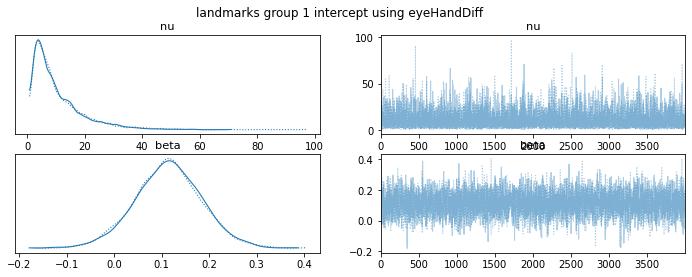

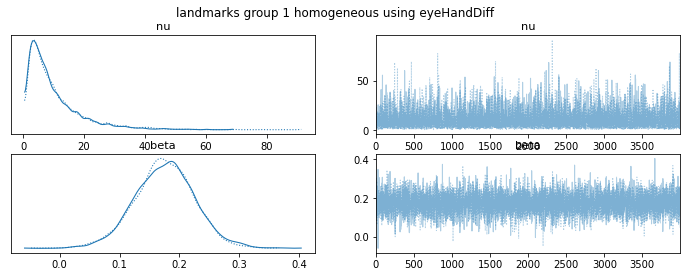

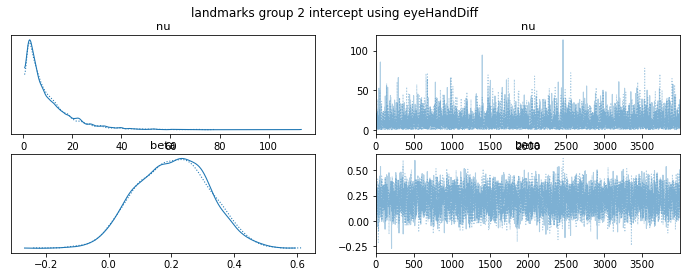

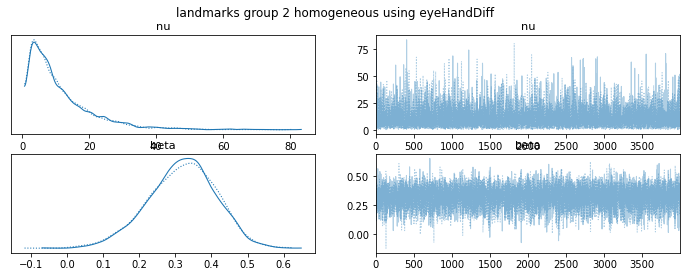

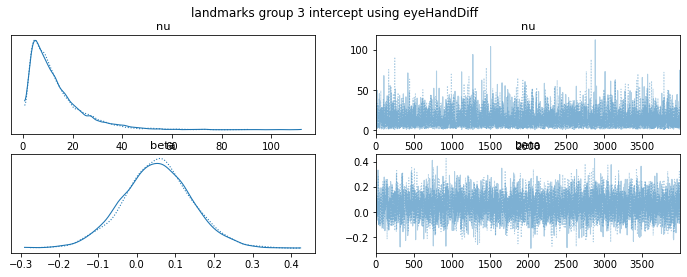

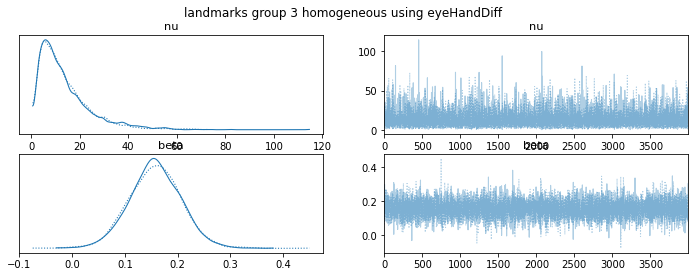

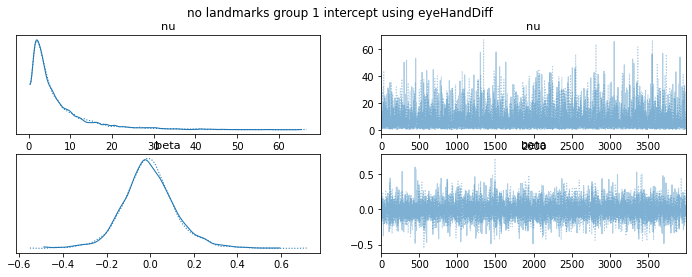

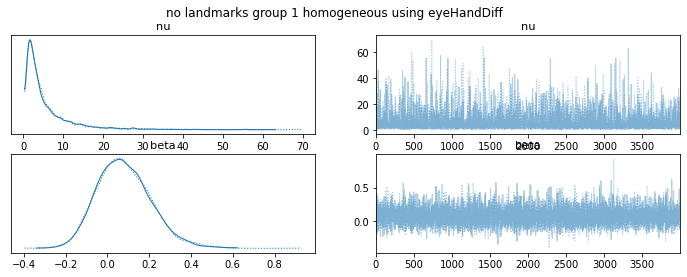

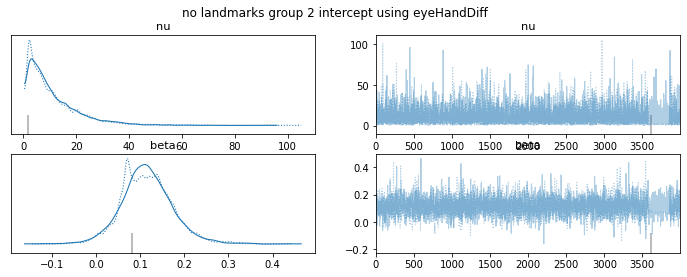

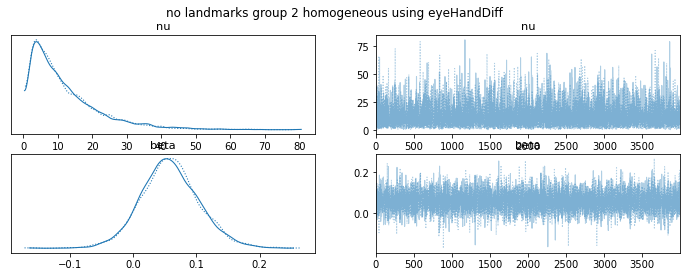

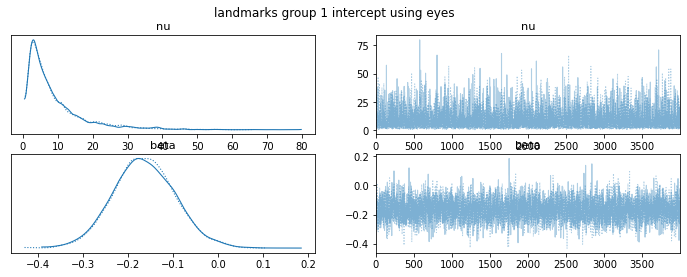

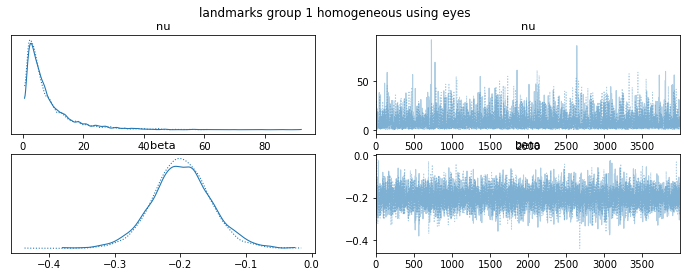

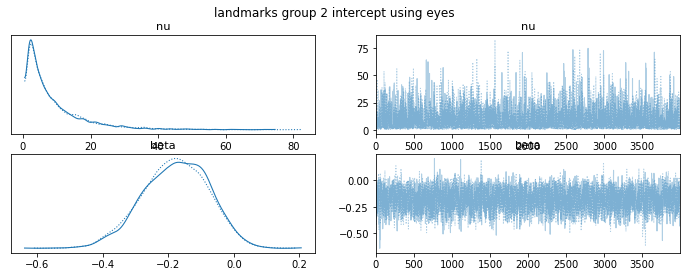

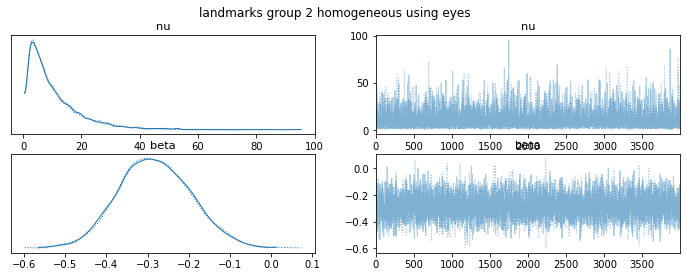

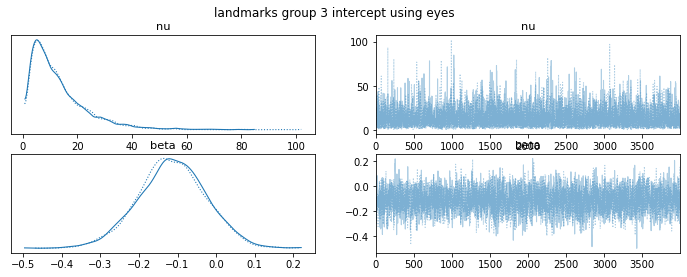

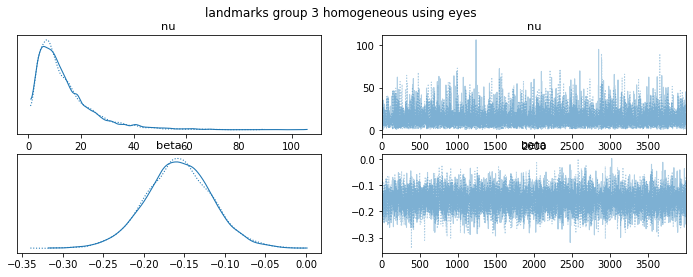

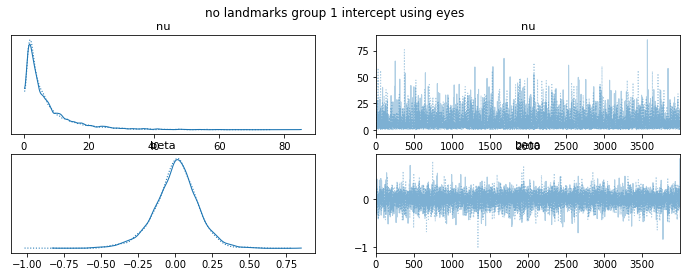

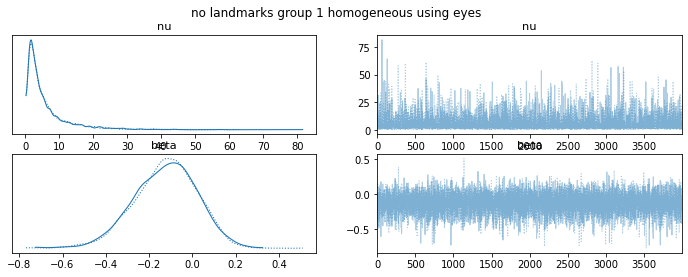

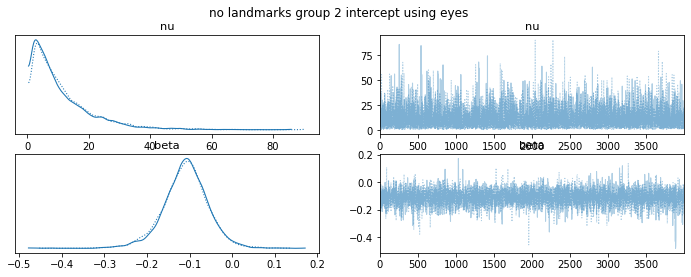

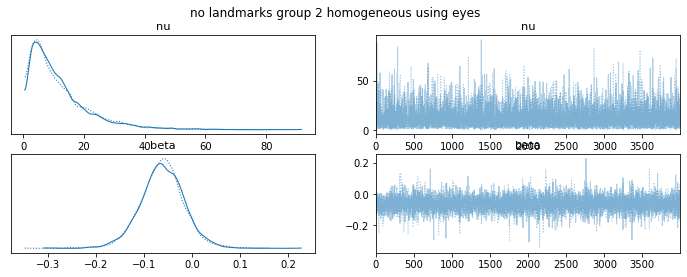

In [22]:
for i in range(num_models):
  for b0_string in b0_strings:
    trace = all_idata[b0_string][i]
    m = model_list[b0_string][i]
    ax = az.plot_trace(trace, var_names=["nu", "beta"])
    ax[0][0].get_figure().suptitle(f'{m["name"]}')

In [33]:
for i in range(num_models):
  for b0_string in b0_strings:
    trace = all_idata[b0_string][i]
    m = model_list[b0_string][i]

    if not m["use_b0"]:
      print('************************')
      print(m["name"])
      print(az.summary(trace, var_names=["beta", "nu"]))
   

************************
landmarks group 1 homogeneous using eyeHandDiff
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.175  0.050   0.080    0.267      0.000     0.00   11476.0    6208.0   
nu    10.114  8.969   0.601   26.973      0.088     0.07    9983.0    6423.0   

      r_hat  
beta    1.0  
nu      1.0  
************************
landmarks group 2 homogeneous using eyeHandDiff
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.318  0.094   0.133    0.483      0.001    0.001    9437.0    5749.0   
nu    11.246  9.698   0.662   28.727      0.098    0.080    8691.0    5788.0   

      r_hat  
beta    1.0  
nu      1.0  
************************
landmarks group 3 homogeneous using eyeHandDiff
        mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.158   0.050   0.066    0.251      0.000    0.000   10874.0    6185.0   
nu    13.563  10.563   1.073   32.827      0.103    0

## Plot regressions

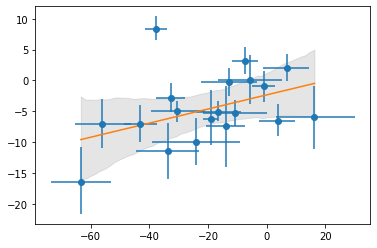

In [18]:
def plot_regression(data: az.InferenceData, m : pd.DataFrame, ax: plt.Axes = None):
    post = data.posterior

    post_mean = post[["xs","ys"]].mean(dim=['chain', 'draw'])
    post_hdi = az.hdi(post[["xs","ys"]])

    x_mean = post_mean["xs"]
    y_mean = post_mean["ys"]
    x_upper = post_hdi["xs"].sel({"hdi":"higher"}) - x_mean
    x_lower = x_mean - post_hdi["xs"].sel({"hdi":"lower"})
    y_upper = post_hdi["ys"].sel({"hdi":"higher"}) - y_mean
    y_lower = y_mean - post_hdi["ys"].sel({"hdi":"lower"})
        
    if ax is None:
        ax = plt.gca()

    ax.errorbar(x_mean, y_mean, xerr=[x_lower, x_upper], yerr=[y_lower, y_upper], fmt='o')

    x_hat = np.linspace(np.min(x_mean), np.max(x_mean), 50)
    x0 = m["x0"]
    y0 = m["y0"]
    beta = post["beta"].mean().to_numpy()
    if m["use_b0"]:
        beta0 = post["beta0"].mean().to_numpy()
    else:
        beta0 = 0

    y_hat = (x_hat-x0)*beta+beta0 + y0

    ax.plot(x_hat, y_hat)

    # az.plot_hdi(post["xs"], post["ys"])

    beta_trace = post["beta"]
    if m["use_b0"]:
        beta0_trace = post["beta0"]
    else:
        beta0_trace = 0

    y_lower = list()
    y_higher = list()
    for x_mod in x_hat:
        y_mod_trace = beta_trace*(x_mod-x0) + beta0_trace + y0
        y_mod_hdi = az.hdi(y_mod_trace).to_array().to_numpy()
        y_lower.append(y_mod_hdi[0][0])
        y_higher.append(y_mod_hdi[0][1])
    ax.fill_between(x_hat, y_lower, y_higher, color='grey', alpha=0.2)
    return ax

plot_regression(all_idata['intercept'][0], model_list['intercept'][0])

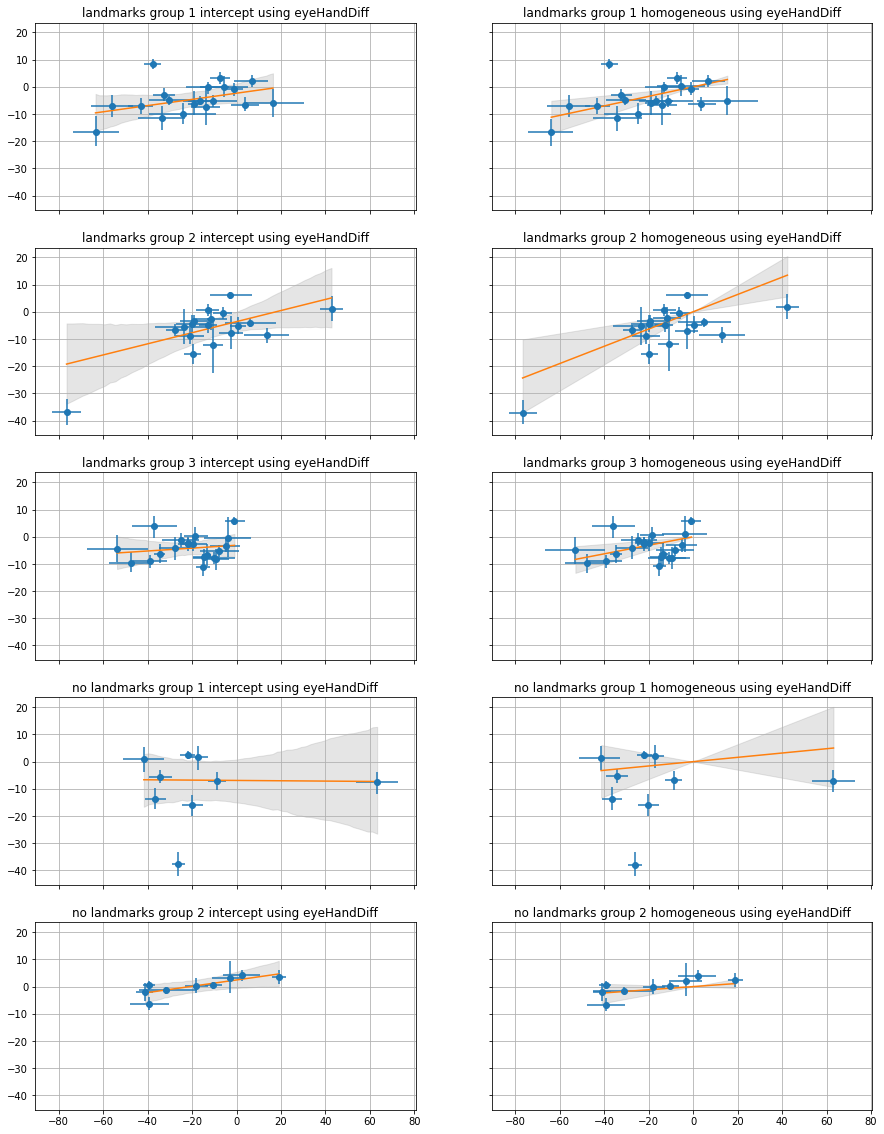

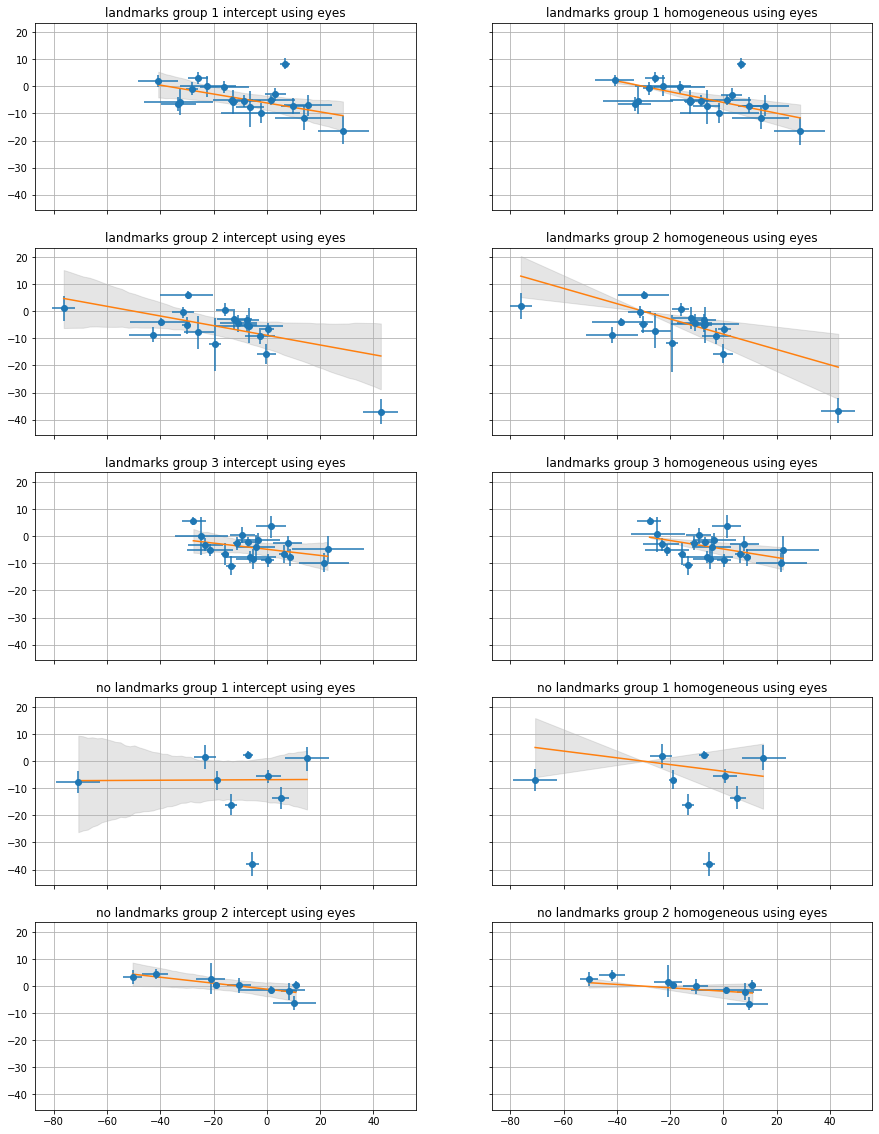

In [19]:
num_models_per_variable = int(num_models/2)
num_variables = 2

for var_num in range(num_variables):
  fig, ax = plt.subplots(nrows=num_models_per_variable, ncols=2, figsize=(15, 20), sharex=True, sharey=True)
  for i in range(num_models_per_variable):
    mi = var_num*num_models_per_variable+i
    for j,b0_string in enumerate(b0_strings):
      trace = all_idata[b0_string][mi]
      m = model_list[b0_string][mi]
      plot_regression(data=trace, m=m, ax=ax[i,j])
      ax[i,j].grid()
      ax[i,j].set_title(m["name"])


## Working on WAIC

In [ ]:
obs_x = idata.observed_data["obs_x"]
s_idx = idata.constant_data["s_idx"]
norm_x = (obs_x-30).groupby(s_idx)
xs = idata.posterior["xs"]
x_sigma = idata.posterior["x_sigma"]
print(xs.coords)

# n_x = xr.Dataset(norm_x, dims=xs.dims)

def calc_score(x, xs, x_sigma):
    print("*******")
    print(f'x={x}')
    print(f'xs={xs}')
    print(f'x_sigma={x_sigma}')
    return x

# xr.apply_ufunc(calc_score, norm_x, xs, x_sigma)
norm_x[0]

In [ ]:
def calculate_log_lik(x, y, xs, ys, ys_mu, x_sigma, y_sigma, ys_sigma):
    ll_ys = stats.norm(ys_mu, ys_sigma).logpdf(ys)
    def ll_points(arr):
        ll_point = lambda x : stats.norm(arr.xs, arr.x_sigma).logpdf(x)
        return arr.x.map()

    ll_x = xr.concat([x, xs, x_sigma]).map(ll_points)
    ll_x = 0
    ll_y = 0
    for i, (xsi, s_x_i, ysi, s_y_i) in enumerate(zip(xs,x_sigma, ys, y_sigma)): 
        xi = x[s_idx == i]
        yi = y[s_idx == i]
        ll_x = ll_x + sum([stats.norm(xsi, s_x_i).logpdf(xij) for xij in xi])
        ll_y = ll_y + sum([stats.norm(ysi, s_y_i).logpdf(yij) for yij in yi])
    
    return ll_ys + ll_x + ll_y

idata = all_idata[b0_strings[0]][0]
m = model_list[b0_strings[0]][0]

(obs_x-30).groupby(s_idx)
log_lik = xr.apply_ufunc(
    calculate_log_lik,
    (idata.observed_data["obs_x"]-m["x0"]).groupby(idata.constant_data["s_idx"]),
    (idata.observed_data["obs_y"]-m["y0"]).groupby(idata.constant_data["s_idx"]),
    idata.posterior["xs"],
    idata.posterior["ys"],
    idata.posterior["ys_mu"],
    idata.posterior["x_sigma"],
    idata.posterior["y_sigma"],
    idata.posterior["ys_sigma"],
)
idata.likelihood["ys"] = log_lik

In [ ]:
all_idata["intercept"][0]

In [ ]:
stats.norm(np.array([1, 4]).T, 1).logpdf(np.array([[1, 2, 3], [3, 4, 5]]))

In [ ]:
for i in range(int(num_models/2)):
  i_diff = i
  i_eyes = i+5
  yesb0 = b0_strings[0]
  nob0 = b0_strings[1]
  name_di = model_list[yesb0][i_diff]["name"]
  name_dh = model_list[nob0][i_diff]["name"]
  name_ei = model_list[yesb0][i_eyes]["name"]
  name_eh = model_list[nob0][i_eyes]["name"]
  print(f'Comparing {name_di} and {name_dh}')
  print(f'{name_ei} and {name_eh}')
  print(az.compare({name_di: all_idata[yesb0][i_diff], name_dh: all_az[nob0][i_diff], 
  name_ei: all_az[yesb0][i_eyes], name_eh: all_az[nob0][i_eyes]}, ic="waic"))
  

In [ ]:
xx = i_row.iloc[0,:]
print(xx["name"])


In [ ]:
model_frame = pd.DataFrame(model_list)

homogenous_rows = model_frame[model_frame["use_b0"] == True]
intercept_indexes = model_frame[model_frame["use_b0"] == False]

h_row = homogenous_rows.isel[0]
group = h_row["group"]
landmarks = h_row["landmarks"]
variable = h_row["variable"]
h = h_row.index

i_row = model_frame[np.invert(model_frame["use_b0"]) & (model_frame["group"] == group) & (model_frame["landmarks"] == landmarks) & (model_frame["variable"] == variable)]
i = i_row.index
